In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import os, os.path
from keras.utils import plot_model
from tensorflow.python.keras.layers import Input, Flatten, Dense, concatenate,  Dropout
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.convolutional import MaxPooling2D
from tensorflow.python.keras.layers.core import Activation
from tensorflow.python.keras.models import Model, load_model, Sequential
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes
import tensorflow as tf
import matplotlib.pyplot as plt, numpy as np
from sklearn.decomposition import PCA
from tensorflow.python.keras import backend as K
import keras.backend.tensorflow_backend as ktf
from glob import glob
from PIL import Image
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras import regularizers
import scipy.io as sio
import xgboost as xgb
from xgboost import plot_importance
import time
import pickle
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
from random import uniform as rdm
from skimage import transform
import imageio
import random
import shutil
import argparse
import collections
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


In [3]:
picSize=224

In [4]:
def transfer(image):
    dat = image.copy()
    min_max = []  # range of channls
    h, w, c = dat.shape
    for i in range(c):
        min_d, max_d = (np.min(dat[:, :, i]), np.max(dat[:, :, i]))
        min_max.append((min_d, max_d))
        zone = max_d - min_d
        if zone < 0.1:
            zone = 0.1
        dat[:, :, i] = 1.0 * (dat[:, :, i] - min_d) / zone * 255
    dat = dat.astype('uint8')
    return dat, min_max

def re_transfer(image, min_max):
    dat0 = image.copy()
    dat0 = dat0.astype('float16')
    h, w, c = dat0.shape
    for i in range(c):
        min_d, max_d = min_max[i]
        min_now, max_now = (np.min(dat0[:, :, i]), np.max(dat0[:, :, i]))
        zone = (max_now - min_now)
        if zone < 0.1:
            zone = 0.1
        dat0[:, :, i] = 1.0 * (dat0[:, :, i] - min_now) / zone * (max_d - min_d) + min_d
    return dat0

def resize(dat1,sz):
    image, min_max = transfer(dat1)
    image = Image.fromarray(image)
    image = image.resize(sz)
    image = np.array(image)
    image = re_transfer(image, min_max)
    return image

In [5]:
def get_data(p, nd, train_dir, anchor_class, test_class):    
    jpgdata = glob(os.path.join(train_dir + str(p)+"/", "*.jpg"))
    jpgdata = np.sort(jpgdata)
    st=0
    x0 = np.zeros((len(range(st,nd,1)), picSize, picSize, 1),dtype='float16')
    if anchor_class == test_class:
        y0 = np.ones((len(range(st,nd,1)),),dtype='uint8')*0
    if anchor_class != test_class:
        y0 = np.ones((len(range(st,nd,1)),),dtype='uint8')*1
    k=-1
    li = [i for i in range(jpgdata.size)]
    j=random.sample(li,nd)    
    for i in range(st,nd,1):
        image = Image.open(jpgdata[j[i]]) 
        image = np.asarray(image) / 255.0
        a=image
        b=a.reshape((picSize,picSize,1))
        k=k+1
        x0[k] = b
    return x0.astype('float16'),y0.astype('uint8')

In [6]:
from itertools import groupby

def get_prediction(mN, p, anchor_class, test_class, saved_txt_name, splitted_img_dir, testSetDir, hasSplitData):    
    print("Test class:",str(test_class), "; Anchor class:", str(anchor_class))
    if hasSplitData == False:
        print("please split your images into sub-images!")
    if hasSplitData == True:
        num_of_img = len([name for name in os.listdir(splitted_img_dir+str(p)+"/") if os.path.isfile(os.path.join(splitted_img_dir+str(p)+"/", name))])
        print('num_of_img:',num_of_img)    
    x_train,y_train = get_data(p, num_of_img, splitted_img_dir, anchor_class, test_class)        
    model2 = load_model("tripOst_"+str(mN)+".h5", compile=False)
    x_train_embeddings = model2.predict(np.reshape(x_train, (len(x_train), picSize, picSize, 1)))
    x_train_emb = np.array(x_train_embeddings)
    dtrain = xgb.DMatrix(x_train_emb, np.array(y_train))
    model4 = xgb.Booster({'nthread':4}) # init model
    model4.load_model("Trmodel_"+str(mN)+".model")  
    
    preds = model4.predict(dtrain)
    np.savetxt(saved_txt_name, preds, delimiter=",")
    pred_2 = np.loadtxt(saved_txt_name) 
        
    #element_counter = collections.Counter(pred_2)
    #print(element_counter)
    #key_list, value_list = element_counter.keys(), element_counter.values()

    predict_dict = {value: len(list(freq)) for value, freq in groupby(sorted(pred_2))}
    print(predict_dict)
    
    ##check whether the key (anchor_class) is in the dictionary (predict_dict)
    if anchor_class in predict_dict: 
        anchor_count = predict_dict[anchor_class]
        prediction_accuracy = (anchor_count/num_of_img)*100
        print("How confident this image belongs to class {0}: {1:.2f}%".format(anchor_class, prediction_accuracy))
        residual_rate = 100 - prediction_accuracy
        print("Residual rate = {0:.2f}%".format(residual_rate))
    else:
        prediction_accuracy = 0
        residual_rate = 100
        print("How confident this image belongs to class {0}: {1:.2f}%".format(anchor_class, prediction_accuracy))
        print("Residual rate = {0:.2f}%".format(residual_rate))
    return prediction_accuracy, residual_rate

In [7]:
def save_list(saved_txt_name, list_content):
    np.savetxt(saved_txt_name, list_content, delimiter=",")

In [8]:
def get_acc_and_residual(splitted_img_dir, testSetDir, mN, anchor_class, test_class, img_num_of_each_class):
    prediction_accuracy_list = []
    residual_rate_list = []
    for p in range(1, img_num_of_each_class+1):
        saved_txt_name = "predictClass_{}-{}_trueClass_{}.txt".format(test_class, p, anchor_class)
        predAcc, resiRate = get_prediction(mN, p, anchor_class, test_class, 
                                           saved_txt_name, splitted_img_dir, testSetDir, True)
        print("")
        prediction_accuracy_list.append(predAcc)
        residual_rate_list.append(resiRate)
    print('Positive_list:', prediction_accuracy_list, '\n')
    print('Negative_list:', residual_rate_list)
    save_list('predictAcc_Positive_PredClass_{}_TrueClass_{}.txt'.format(test_class, anchor_class), prediction_accuracy_list)
    save_list('predictAcc_Negative_PredClass_{}_TrueClass_{}.txt'.format(test_class, anchor_class), residual_rate_list)
    return prediction_accuracy_list, residual_rate_list

In [9]:
def plot_the_results(prediction_accuracy_list, residual_rate_list, anchor_class, test_class):
    plt.plot(prediction_accuracy_list, 'ro', label='Positive')
    plt.plot(residual_rate_list, 'bo', label='Negative')
    plt.title('Predict Class: {}, True Class: {}'.format(test_class, anchor_class))
    plt.xlabel('Image order', fontsize=12)
    plt.ylabel('Voting score percentage', fontsize=12)
    plt.legend()
    plt.show()

In [10]:
from scipy.stats import ttest_ind
def welch_t_test(prediction_accuracy_list, residual_rate_list):
    statistic, pvalue = ttest_ind(prediction_accuracy_list, residual_rate_list)
    print('Statistics = %.10f' % (statistic))
    print('p value = %.5f' % (pvalue))

## True class = 0, Test class = 0

In [11]:
splitted_img_dir = '/raid/home/ben/_kunyi/triplet_net/tea_3/tea_image_datasets/13_tea_classes_splittedImgs/13_tea_classes_V4_iphoneFormat_onlyOolongTea_trainValTest/test_oneImg_to_oneFolder/class_0/'
mN = 0
anchor_class = 0
test_class = 0
prediction_accuracy_list_00, residual_rate_list_00 = get_acc_and_residual(splitted_img_dir, None, 
                                                                          mN, anchor_class, test_class, 6)

Test class: 0 ; Anchor class: 0
num_of_img: 3026
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
{0.0: 1765, 1.0: 755, 2.0: 310, 3.0: 13, 4.0: 152, 5.0: 31}
How confident this image belongs to class 0: 58.33%
Residual rate = 41.67%

Test class: 0 ; Anchor class: 0
num_of_img: 3026
{0.0: 2709, 1.0: 113, 2.0: 69, 3.0: 4, 4.0: 128, 5.0: 3}
How confident this image belongs to class 0: 89.52%
Residual rate = 10.48%

Test class: 0 ; Anchor class: 0
num_of_img: 3026
{0.0: 2702, 1.0: 272, 2.0: 34, 3.0: 4, 4.0: 14}
How confident this image belongs to class 0: 89.29%
Residual rate = 10.71%

Test class: 0 ; Anchor class: 0
num_of_img: 3026
{0.0: 2957, 1.0: 37, 2.0: 14, 3.0: 6, 4.0: 12}
How confident this image belongs to class 0: 97.72%
Residual rate = 2.28%

Test class: 0 ; Anchor class: 0
num_of_img: 3026
{0.0: 2689, 1.0: 134, 2.0: 180, 3.0: 12, 4.0: 6, 5.0: 5}
How confident this image belongs to class 0: 88.86%
Residual rate = 11.14%

Test class: 0 ; Anchor cla

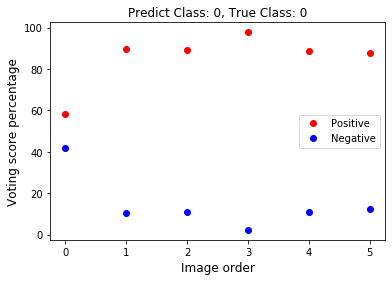

Statistics = 8.9321508838
p value = 0.00000


In [12]:
plot_the_results(prediction_accuracy_list_00, residual_rate_list_00, anchor_class, test_class)
welch_t_test(prediction_accuracy_list_00, residual_rate_list_00)

## True class = 0, Test class = 1

In [13]:
splitted_img_dir = '/raid/home/ben/_kunyi/triplet_net/tea_3/tea_image_datasets/13_tea_classes_splittedImgs/13_tea_classes_V4_iphoneFormat_onlyOolongTea_trainValTest/test_oneImg_to_oneFolder/class_1/'
test_class = 1
prediction_accuracy_list_01, residual_rate_list_01 = get_acc_and_residual(splitted_img_dir, None, 
                                                                          mN, anchor_class, test_class, 6)

Test class: 1 ; Anchor class: 0
num_of_img: 3026
{0.0: 1076, 1.0: 1946, 2.0: 2, 3.0: 1, 4.0: 1}
How confident this image belongs to class 0: 35.56%
Residual rate = 64.44%

Test class: 1 ; Anchor class: 0
num_of_img: 3026
{0.0: 747, 1.0: 2198, 2.0: 80, 3.0: 1}
How confident this image belongs to class 0: 24.69%
Residual rate = 75.31%

Test class: 1 ; Anchor class: 0
num_of_img: 3026
{0.0: 202, 1.0: 2309, 2.0: 463, 3.0: 1, 4.0: 10, 5.0: 41}
How confident this image belongs to class 0: 6.68%
Residual rate = 93.32%

Test class: 1 ; Anchor class: 0
num_of_img: 3026
{0.0: 402, 1.0: 2501, 2.0: 120, 4.0: 2, 5.0: 1}
How confident this image belongs to class 0: 13.28%
Residual rate = 86.72%

Test class: 1 ; Anchor class: 0
num_of_img: 3026
{0.0: 850, 1.0: 2048, 2.0: 125, 4.0: 2, 5.0: 1}
How confident this image belongs to class 0: 28.09%
Residual rate = 71.91%

Test class: 1 ; Anchor class: 0
num_of_img: 3026
{0.0: 364, 1.0: 2146, 2.0: 435, 3.0: 1, 4.0: 10, 5.0: 70}
How confident this image belo

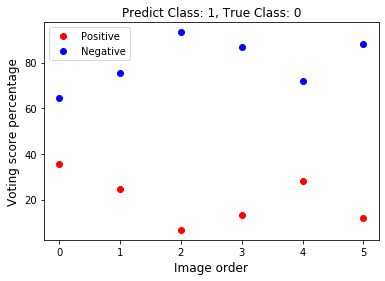

Statistics = -9.3488090132
p value = 0.00000


In [14]:
plot_the_results(prediction_accuracy_list_01, residual_rate_list_01, anchor_class, test_class)
welch_t_test(prediction_accuracy_list_01, residual_rate_list_01)

## True class = 0, Test class = 2

In [15]:
splitted_img_dir = '/raid/home/ben/_kunyi/triplet_net/tea_3/tea_image_datasets/13_tea_classes_splittedImgs/13_tea_classes_V4_iphoneFormat_onlyOolongTea_trainValTest/test_oneImg_to_oneFolder/class_2/'
test_class = 2
prediction_accuracy_list_02, residual_rate_list_02 = get_acc_and_residual(splitted_img_dir, None, 
                                                                          mN, anchor_class, test_class, 6)

Test class: 2 ; Anchor class: 0
num_of_img: 3026
{0.0: 391, 1.0: 71, 2.0: 1859, 3.0: 45, 4.0: 453, 5.0: 207}
How confident this image belongs to class 0: 12.92%
Residual rate = 87.08%

Test class: 2 ; Anchor class: 0
num_of_img: 3026
{0.0: 722, 1.0: 57, 2.0: 1467, 3.0: 105, 4.0: 573, 5.0: 102}
How confident this image belongs to class 0: 23.86%
Residual rate = 76.14%

Test class: 2 ; Anchor class: 0
num_of_img: 3026
{0.0: 427, 1.0: 233, 2.0: 1844, 3.0: 2, 4.0: 194, 5.0: 326}
How confident this image belongs to class 0: 14.11%
Residual rate = 85.89%

Test class: 2 ; Anchor class: 0
num_of_img: 3026
{0.0: 780, 1.0: 54, 2.0: 1289, 3.0: 77, 4.0: 645, 5.0: 181}
How confident this image belongs to class 0: 25.78%
Residual rate = 74.22%

Test class: 2 ; Anchor class: 0
num_of_img: 3026
{0.0: 474, 1.0: 99, 2.0: 2013, 3.0: 14, 4.0: 207, 5.0: 219}
How confident this image belongs to class 0: 15.66%
Residual rate = 84.34%

Test class: 2 ; Anchor class: 0
num_of_img: 3026
{0.0: 739, 1.0: 103, 2.0:

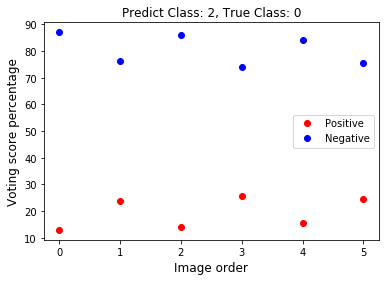

Statistics = -18.1626960123
p value = 0.00000


In [16]:
plot_the_results(prediction_accuracy_list_02, residual_rate_list_02, anchor_class, test_class)
welch_t_test(prediction_accuracy_list_02, residual_rate_list_02)

## True class = 0, Test class = 3

In [17]:
splitted_img_dir = '/raid/home/ben/_kunyi/triplet_net/tea_3/tea_image_datasets/13_tea_classes_splittedImgs/13_tea_classes_V4_iphoneFormat_onlyOolongTea_trainValTest/test_oneImg_to_oneFolder/class_3/'
test_class = 3
prediction_accuracy_list_03, residual_rate_list_03 = get_acc_and_residual(splitted_img_dir, None, 
                                                                          mN, anchor_class, test_class, 6)

Test class: 3 ; Anchor class: 0
num_of_img: 3026
{0.0: 54, 2.0: 14, 3.0: 2743, 4.0: 197, 5.0: 18}
How confident this image belongs to class 0: 1.78%
Residual rate = 98.22%

Test class: 3 ; Anchor class: 0
num_of_img: 3026
{0.0: 75, 2.0: 12, 3.0: 2779, 4.0: 145, 5.0: 15}
How confident this image belongs to class 0: 2.48%
Residual rate = 97.52%

Test class: 3 ; Anchor class: 0
num_of_img: 3026
{0.0: 297, 2.0: 7, 3.0: 2571, 4.0: 147, 5.0: 4}
How confident this image belongs to class 0: 9.81%
Residual rate = 90.19%

Test class: 3 ; Anchor class: 0
num_of_img: 3026
{0.0: 539, 2.0: 15, 3.0: 2269, 4.0: 193, 5.0: 10}
How confident this image belongs to class 0: 17.81%
Residual rate = 82.19%

Test class: 3 ; Anchor class: 0
num_of_img: 3026
{0.0: 340, 2.0: 7, 3.0: 2638, 4.0: 36, 5.0: 5}
How confident this image belongs to class 0: 11.24%
Residual rate = 88.76%

Test class: 3 ; Anchor class: 0
num_of_img: 3026
{0.0: 90, 2.0: 11, 3.0: 2791, 4.0: 127, 5.0: 7}
How confident this image belongs to cl

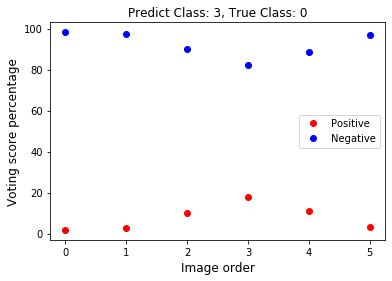

Statistics = -22.9593933005
p value = 0.00000


In [18]:
plot_the_results(prediction_accuracy_list_03, residual_rate_list_03, anchor_class, test_class)
welch_t_test(prediction_accuracy_list_03, residual_rate_list_03)

## True class = 0, Test class = 4

In [19]:
splitted_img_dir = '/raid/home/ben/_kunyi/triplet_net/tea_3/tea_image_datasets/13_tea_classes_splittedImgs/13_tea_classes_V4_iphoneFormat_onlyOolongTea_trainValTest/test_oneImg_to_oneFolder/class_4/'
test_class = 4
prediction_accuracy_list_04, residual_rate_list_04 = get_acc_and_residual(splitted_img_dir, None, 
                                                                          mN, anchor_class, test_class, 6)

Test class: 4 ; Anchor class: 0
num_of_img: 3026
{0.0: 519, 2.0: 244, 3.0: 597, 4.0: 1491, 5.0: 175}
How confident this image belongs to class 0: 17.15%
Residual rate = 82.85%

Test class: 4 ; Anchor class: 0
num_of_img: 3026
{0.0: 52, 2.0: 124, 3.0: 271, 4.0: 2130, 5.0: 449}
How confident this image belongs to class 0: 1.72%
Residual rate = 98.28%

Test class: 4 ; Anchor class: 0
num_of_img: 3026
{0.0: 103, 1.0: 156, 2.0: 397, 3.0: 28, 4.0: 1492, 5.0: 850}
How confident this image belongs to class 0: 3.40%
Residual rate = 96.60%

Test class: 4 ; Anchor class: 0
num_of_img: 3026
{0.0: 237, 1.0: 3, 2.0: 755, 3.0: 99, 4.0: 1609, 5.0: 323}
How confident this image belongs to class 0: 7.83%
Residual rate = 92.17%

Test class: 4 ; Anchor class: 0
num_of_img: 3026
{0.0: 357, 1.0: 16, 2.0: 835, 3.0: 110, 4.0: 1397, 5.0: 311}
How confident this image belongs to class 0: 11.80%
Residual rate = 88.20%

Test class: 4 ; Anchor class: 0
num_of_img: 3026
{0.0: 172, 2.0: 298, 3.0: 216, 4.0: 2000, 5.0

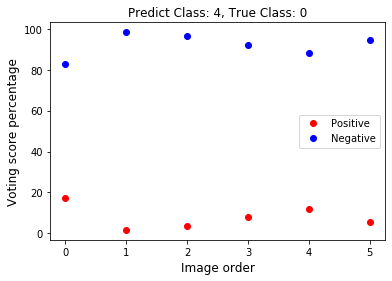

Statistics = -25.4366090745
p value = 0.00000


In [20]:
plot_the_results(prediction_accuracy_list_04, residual_rate_list_04, anchor_class, test_class)
welch_t_test(prediction_accuracy_list_04, residual_rate_list_04)

## True class = 0, Test class = 5

In [21]:
splitted_img_dir = '/raid/home/ben/_kunyi/triplet_net/tea_3/tea_image_datasets/13_tea_classes_splittedImgs/13_tea_classes_V4_iphoneFormat_onlyOolongTea_trainValTest/test_oneImg_to_oneFolder/class_5/'
test_class = 5
prediction_accuracy_list_05, residual_rate_list_05 = get_acc_and_residual(splitted_img_dir, None, 
                                                                          mN, anchor_class, test_class, 6)

Test class: 5 ; Anchor class: 0
num_of_img: 3026
{0.0: 9, 1.0: 2, 2.0: 127, 3.0: 7, 4.0: 417, 5.0: 2464}
How confident this image belongs to class 0: 0.30%
Residual rate = 99.70%

Test class: 5 ; Anchor class: 0
num_of_img: 3026
{0.0: 163, 1.0: 5, 2.0: 237, 3.0: 92, 4.0: 907, 5.0: 1622}
How confident this image belongs to class 0: 5.39%
Residual rate = 94.61%

Test class: 5 ; Anchor class: 0
num_of_img: 3026
{0.0: 14, 1.0: 3, 2.0: 302, 3.0: 10, 4.0: 349, 5.0: 2348}
How confident this image belongs to class 0: 0.46%
Residual rate = 99.54%

Test class: 5 ; Anchor class: 0
num_of_img: 3026
{0.0: 24, 2.0: 134, 3.0: 25, 4.0: 1029, 5.0: 1814}
How confident this image belongs to class 0: 0.79%
Residual rate = 99.21%

Test class: 5 ; Anchor class: 0
num_of_img: 3026
{0.0: 84, 1.0: 25, 2.0: 363, 3.0: 9, 4.0: 425, 5.0: 2120}
How confident this image belongs to class 0: 2.78%
Residual rate = 97.22%

Test class: 5 ; Anchor class: 0
num_of_img: 3026
{0.0: 236, 1.0: 1, 2.0: 266, 3.0: 101, 4.0: 1012,

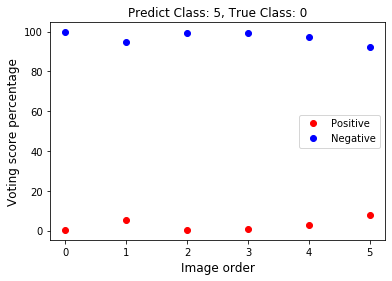

Statistics = -52.9977712891
p value = 0.00000


In [22]:
plot_the_results(prediction_accuracy_list_05, residual_rate_list_05, anchor_class, test_class)
welch_t_test(prediction_accuracy_list_05, residual_rate_list_05)